**Visual Inspection of LOC EEG Data**

This notebook performs the visual quality check of the LOC EEG recordings after BIDS conversion. The goal is to assess data quality & interpolate bad channels before proceeding to the next preprocessing steps.

Specifally, this notebook:
- loads the BIDS-formatted EEG data
- extracts and visually inspects the recorded events
- evaluates power line noise using PSD plots
- adds manual and automatic annotations, including:
a. break periods 
b. muscular activity (EMG) artifacts 
c. bad channels

Things I need to do:
[x] Clean-up the section where annotations are saved
[x] I also wanna save the output file of the downsampling. Naming conventions and where to save? Check with BIDS requirements: sub-01_task-loc_downsample-2_eeg
[x] Check where I should output the annotations .csv file to.
[x] Set up and run bad channel selection and interpolation
[] Check in with ROdi if our chosen default montage is correct (in 01_BIDS_conversion) + also ask her about re-calibrating the electrodes to increase SNR of the recording
[x] Schedule next piloting for Tuesday with Maragita's frind
[] Set up the protocol
[] We also need an EEG log book for next week! --> Juan shared a template, just need to copy it

In [1]:
# 1. Imports
import numpy as np
import mne
from mne_bids import BIDSPath, read_raw_bids
from pathlib import Path
import os

# 2. Configuration
bids_root = Path(r"C:\Users\noahm\projects\loc_analysis\data\derivatives")
sub_number = "01"
task = "loc"
suffix = "eeg"

# Define Output Filenames
# We save the downsampled file to avoid re-processing every time
deriv_root = bids_root  / f"sub-{sub_number}" / "eeg"

# Output 1: Downsampled EEG File
fname_downsampled = deriv_root / f"sub-{sub_number}_task-{task}_downsamp-2_eeg.fif"
# Output 2: Annotations CSV
fname_annots = deriv_root / f"sub-{sub_number}_task-{task}_desc-annotations.csv"

print(f"Working on Subject: {sub_number}")
print(f"Downsampled file path: {fname_downsampled}")
print(f"Annotations file path: {fname_annots}")

Working on Subject: 01
Downsampled file path: C:\Users\noahm\projects\loc_analysis\data\derivatives\sub-01\eeg\sub-01_task-loc_downsamp-2_eeg.fif
Annotations file path: C:\Users\noahm\projects\loc_analysis\data\derivatives\sub-01\eeg\sub-01_task-loc_desc-annotations.csv


In [2]:
# Check if downsampled file already exists
if fname_downsampled.exists():
    print("Found existing downsampled file. Loading...")
    raw_eeg = mne.io.read_raw_fif(fname_downsampled, preload=True)
    print(raw_eeg.info)
else:
    print("No downsampled file found. Loading from BIDS and processing...")
    # 1. Define BIDS Path
    bids_path = BIDSPath(
        root=bids_root, 
        subject=sub_number, 
        task=task, 
        datatype="eeg", 
        suffix=suffix
    )
    
    # 2. Load Raw
    raw_eeg = read_raw_bids(bids_path=bids_path, verbose=False)
    
    # 3. Downsample (and resample events simultaneously)
    print(f"Original sampling rate: {raw_eeg.info['sfreq']} Hz")
    events, event_id = mne.events_from_annotations(raw_eeg, verbose=False)
    raw_eeg, events = raw_eeg.resample(500, events=events)
    print(f"New sampling rate: {raw_eeg.info['sfreq']} Hz")
    
    # 4. Save for future use
    raw_eeg.save(fname_downsampled, overwrite=True)
    print(f"Saved downsampled file to: {fname_downsampled}")

# Extract events (refreshing them just in case)
events, event_id = mne.events_from_annotations(raw_eeg, verbose=False)

Found existing downsampled file. Loading...
Opening raw data file C:\Users\noahm\projects\loc_analysis\data\derivatives\sub-01\eeg\sub-01_task-loc_downsamp-2_eeg.fif...
    Range : 0 ... 1554879 =      0.000 ...  3109.758 secs
Ready.
Reading 0 ... 1554879  =      0.000 ...  3109.758 secs...
<Info | 15 non-empty values
 bads: 1 items (AF8)
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 63 EEG, 2 EOG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 66 items (3 Cardinal, 63 EEG)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 line_freq: 50.0
 lowpass: 250.0 Hz
 meas_date: 2025-12-02 11:40:38 UTC
 meas_id: 4 items (dict)
 nchan: 65
 projs: []
 sfreq: 500.0 Hz
 subject_info: <subject_info | his_id: sub-01, sex: 0, hand: 0>
>


Quick sanity check of Triggers & PSD

C:\Users\noahm\AppData\Local\Temp\ipykernel_29596\3495199416.py:2: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig_ev = mne.viz.plot_events(


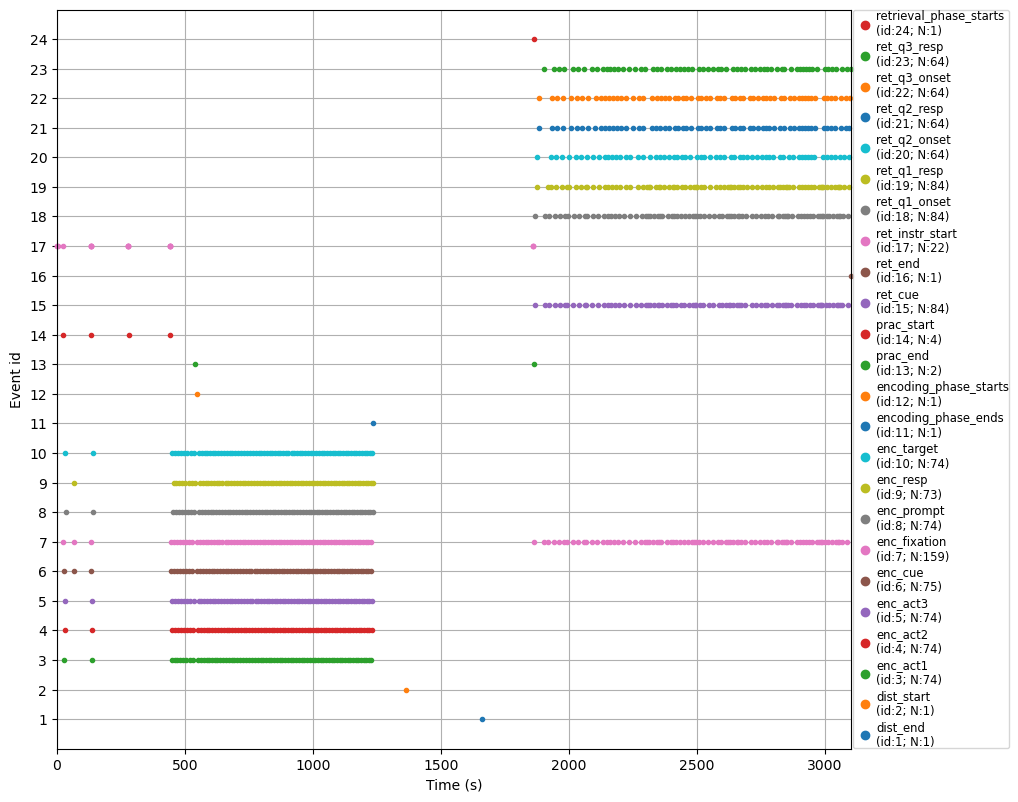

In [3]:
# 1. Plot Events
fig_ev = mne.viz.plot_events(
    events, 
    sfreq=raw_eeg.info["sfreq"], 
    first_samp=raw_eeg.first_samp, 
    event_id=event_id
)

Setting 424017 of 1554880 (27.27%) samples to NaN, retaining 1130863 (72.73%) samples.
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


c:\Users\noahm\mne-python\1.11.0_0\Lib\site-packages\mne\viz\utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


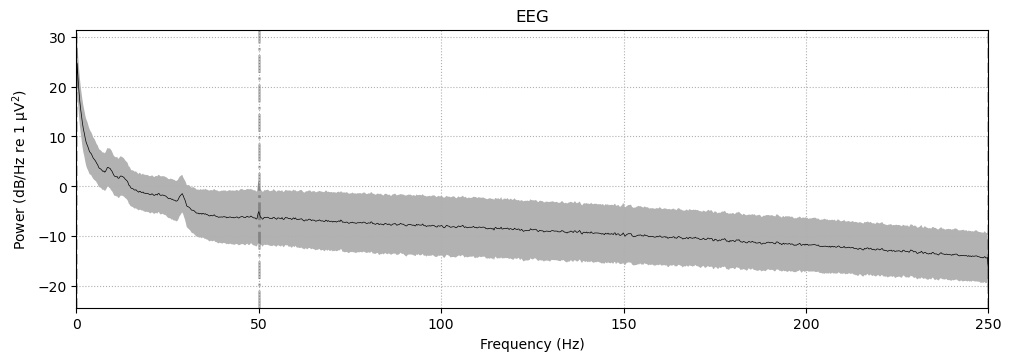

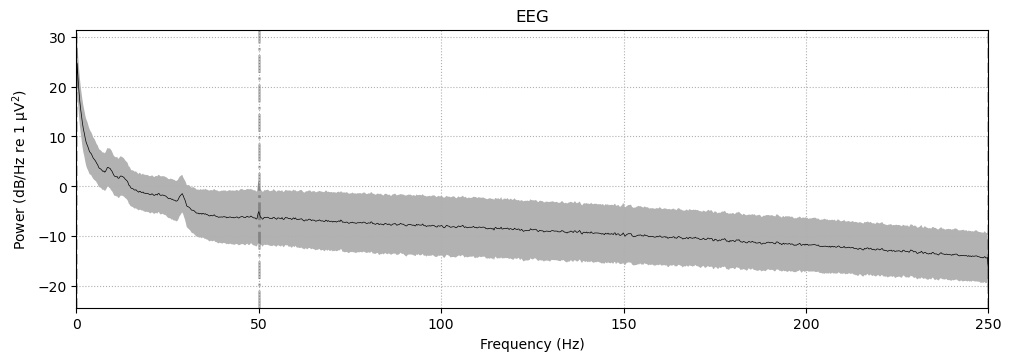

In [4]:
# 2. Plot PSD (Power Line Noise check)
raw_eeg.compute_psd(tmax=np.inf, fmax=250).plot(
    average=True, picks="data", exclude="bads"
)

In [5]:
# 1. Preserve original stimulus triggers (we will need these later!)
#    We assume the file started with stimulus annotations from BIDS.
stimulus_annotations = raw_eeg.annotations.copy()

# 2. Check if we have a saved annotation CSV (Resume work?)
if fname_annots.exists():
    print(f"Loading existing annotations from {fname_annots.name}")
    # If loading previous work, it likely contains everything (Stim + Breaks + Muscle).
    # If you still want to inspect blindly, we'd need to filter this, 
    # but usually if a file exists, inspection is already done.
    saved_annots = mne.read_annotations(fname_annots)
    raw_eeg.set_annotations(saved_annots)

else:
    print("No existing annotations found. Preparing for BLIND visual inspection...")
    
    # --- AUTO-GENERATION LOGIC ---
    id_enc_start, id_dist_start, id_dist_end = 12, 2, 1
    
    try:
        samp_enc_start = events[events[:, 2] == id_enc_start, 0][0]
        samp_dist_start = events[events[:, 2] == id_dist_start, 0][0]
        samp_dist_end   = events[events[:, 2] == id_dist_end, 0][0]
        
        # Calculate timing
        sfreq = raw_eeg.info['sfreq']
        first_samp = raw_eeg.first_samp
        
        onset_1 = 0
        dur_1 = (samp_enc_start - first_samp) / sfreq
        
        onset_2 = (samp_dist_start - first_samp) / sfreq
        dur_2 = (samp_dist_end - samp_dist_start) / sfreq
        
        # Create Break Annotations
        break_annots = mne.Annotations(
            onset=[onset_1, onset_2],
            duration=[dur_1, dur_2],
            description=['BAD_break', 'BAD_distractor']
        )
        
        # --- CRITICAL CHANGE FOR BLIND INSPECTION ---
        # We overwrite the current annotations with ONLY the breaks.
        # The stimulus_annotations are safe in the variable we created at the top.
        raw_eeg.set_annotations(break_annots)
        print("Applied Break annotations only. Stimulus triggers hidden for inspection.")
        
    except IndexError:
        print("Warning: Could not find all trigger events. Annotations not updated.")

Loading existing annotations from sub-01_task-loc_desc-annotations.csv


In [ ]:
# Visual Inspection
scaling_dict = dict(eeg=20e-6)

# We pass events=None so MNE doesn't draw vertical event lines.
# We rely solely on the 'break_annots' we set in Cell 4.
fig = raw_eeg.plot(
    events=None,        # Hides vertical lines
    event_id=None,      # Hides event text
    duration=10, 
    n_channels=32, 
    scalings=scaling_dict,
    theme="light" 
)

print("INSTRUCTIONS:")
print("1. Press 'a' to enter annotation mode.")
print("2. Create a new label 'BAD_muscle' (or similar).")
print("3. Mark artifacts.")
print("4. Close the window when finished to proceed to Cell 6.")

Using qt as 2D backend.
INSTRUCTIONS:
1. Press 'a' to enter annotation mode.
2. Create a new label 'BAD_muscle' (or similar).
3. Mark artifacts.
4. Close the window when finished to proceed to Cell 6.


Channels marked as bad:
['AF8']


In [17]:
# ---------------------------------------------------------
# STEP 6: MERGE & SAVE ANNOTATIONS
# ---------------------------------------------------------

# 1. Retrieve the manual work from the interactive plot
#    This currently contains [Breaks + Muscle Artifacts]
manual_annotations = raw_eeg.annotations.copy()

# 2. Merge with the original stimulus triggers
#    We assume 'stimulus_annotations' was saved in Cell 4
if 'stimulus_annotations' in locals():
    # Combine: Original Triggers + New Manual Markings
    final_annots = manual_annotations + stimulus_annotations
    
    # Apply to raw object
    raw_eeg.set_annotations(final_annots)
    print("Merged manual artifacts with original stimulus triggers.")
else:
    print("Warning: 'stimulus_annotations' variable not found. Did you run Cell 4?")

# 3. Save to CSV
#    This file now contains the "Gold Standard" of your cleaning so far
raw_eeg.annotations.save(fname_annots, overwrite=True)
print(f"SUCCESS: Full annotation set saved to: {fname_annots}")

Merged manual artifacts with original stimulus triggers.
SUCCESS: Full annotation set saved to: C:\Users\noahm\projects\loc_analysis\data\derivatives\sub-01\eeg\sub-01_task-loc_desc-annotations2.csv


No bad channels marked yet. Generating diagnostic plots...
Plotting topomaps for event: 'enc_fixation' (ID: 7)


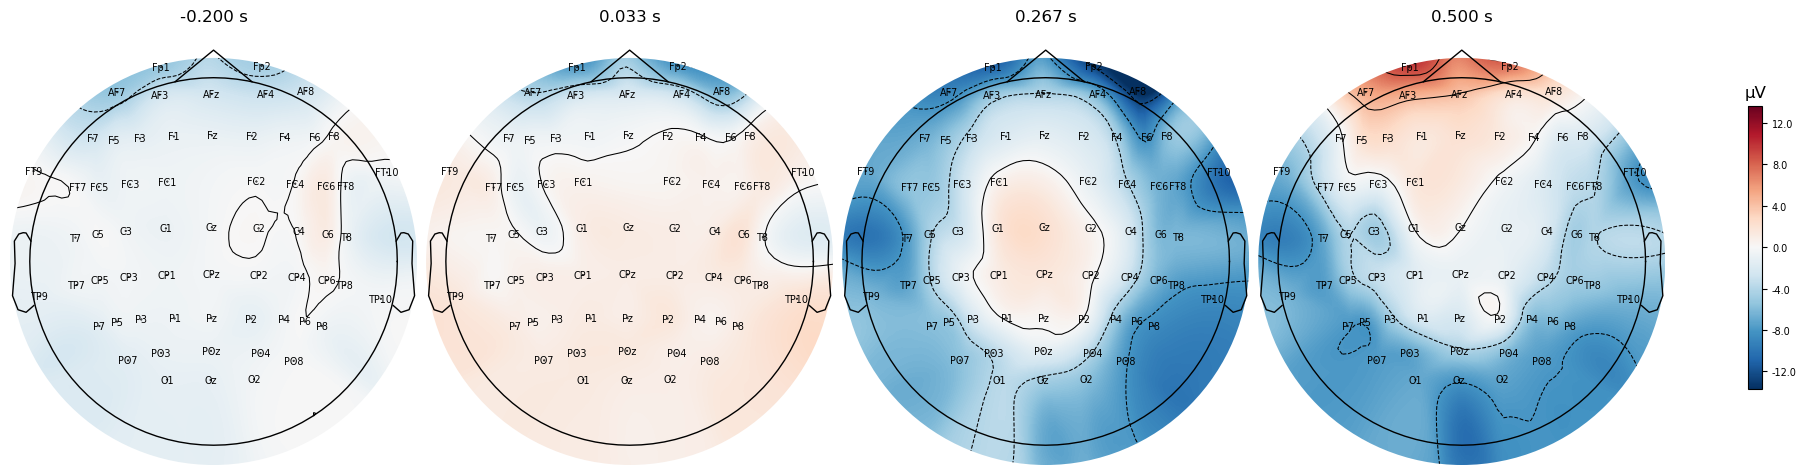

In [19]:
# ---------------------------------------------------------
# STEP 7: BAD CHANNEL INSPECTION (Topo Plots)
# ---------------------------------------------------------

# 1. Check if bads are already marked
current_bads = raw_eeg.info['bads']

if len(current_bads) > 0:
    print(f"Bad channels are already marked: {current_bads}")
    print("Skipping automatic visualization. (If you want to re-check, clear 'raw_eeg.info['bads']' first).")

else:
    print("No bad channels marked yet. Generating diagnostic plots...")
    
    # 2. Define the specific event we want to inspect
    target_event_name = 'enc_fixation'
    target_event_id = 7
    
    # Re-extract events (just to be safe and ensure we have the latest)
    events, event_dict = mne.events_from_annotations(raw_eeg, verbose=False)
    
    # Check if our target ID exists in the events
    if target_event_id in events[:, 2]:
        print(f"Plotting topomaps for event: '{target_event_name}' (ID: {target_event_id})")

        # 3. Create Epochs for the specific event
        epochs_viz = mne.Epochs(
            raw_eeg,
            events,
            event_id={target_event_name: target_event_id},
            tmin=-0.2, tmax=0.5,
            baseline=(None, 0),
            preload=True,
            reject_by_annotation=True, # Exclude the muscle artifacts/breaks we just marked!
            verbose=False
        )
        
        # 4. Plot Topomap
        #    Look for "Red" or "Blue" spots that look completely different from neighbors
        fig_topo = epochs_viz.average().plot_topomap(show_names=True, size=3)
        
    else:
        print(f"Error: Event ID {target_event_id} ('{target_event_name}') not found in the data.")
        print(f"Available Event IDs: {np.unique(events[:, 2])}")

Updated Bad Channels: ['AF8']

Plotting bad channels BEFORE interpolation...
Need more than one channel to make topography for eeg. Disabling interactivity.


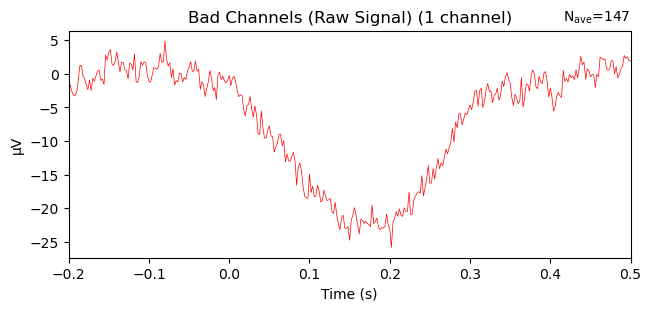

Simulating interpolation for verification...
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.7 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 1 sensors
Need more than one channel to make topography for eeg. Disabling interactivity.


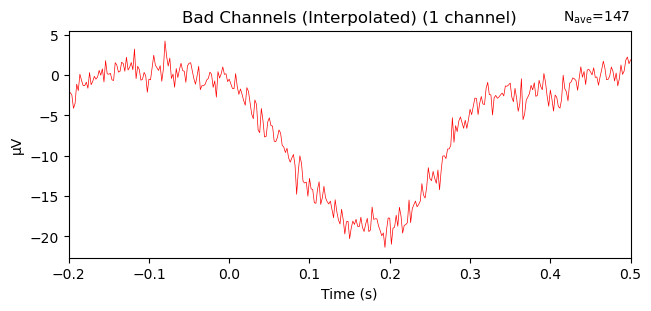

In [35]:
# ---------------------------------------------------------
# STEP 8: MARK BADS & VERIFY INTERPOLATION
# ---------------------------------------------------------

# 1. DEFINE BAD CHANNELS MANUALLY HERE
new_bads = ['AF8'] 

# Add them to the raw object
if new_bads:
    raw_eeg.info['bads'].extend(new_bads)
    # Remove duplicates just in case
    raw_eeg.info['bads'] = list(set(raw_eeg.info['bads']))
    print(f"Updated Bad Channels: {raw_eeg.info['bads']}")
else:
    print(f"No new bad channels added. Current bads: {raw_eeg.info['bads']}")

# 2. Verify with Interpolation (Visual Check Only)
if raw_eeg.info['bads']:
    
    # --- PLOT 1: BEFORE FIX (The Broken Bone) ---
    print("\nPlotting bad channels BEFORE interpolation...")
    epochs_bad = mne.Epochs(raw_eeg, events, event_id={target_event_name: target_event_id}, 
                            tmin=-0.2, tmax=0.5, reject=None, verbose=False)
    
    # FIX: We add exclude=[] so MNE actually shows us the "bad" channel
    epochs_bad.average().plot(picks=new_bads, exclude=[], titles="Bad Channels (Raw Signal)")

    # --- PLOT 2: AFTER FIX (The Verification) ---
    print("Simulating interpolation for verification...")
    # Create temp copy and interpolate
    raw_interp = raw_eeg.copy().load_data().interpolate_bads(reset_bads=False)
    
    # Recalculate epochs on the clean data
    epochs_clean = mne.Epochs(
        raw_interp, 
        events, 
        event_id={target_event_name: target_event_id},
        tmin=-0.2, tmax=0.5, 
        reject=None,
        verbose=False
    )
    # Plot the same sensors (now reconstructed)
    epochs_clean.average().plot(picks=new_bads, exclude=[], titles="Bad Channels (Interpolated)")
    
else:
    print("No bad channels to interpolate.")

In [ ]:
# ---------------------------------------------------------
# STEP 9: SAVE DATA & LOG BAD CHANNELS
# ---------------------------------------------------------
import pandas as pd
from datetime import datetime

# 1. SAVE THE EEG DATA (With Bad Channels Marked)
# ---------------------------------------------------
# We save the file with the bad channels listed in 'raw_eeg.info['bads']'
# We do NOT save the interpolated version (raw_interp) to disk yet.
# This preserves the ability to run ICA correctly later.

raw_eeg.save(fname_downsampled, overwrite=True)
print(f"Saved preprocessed EEG to: {fname_downsampled}")
print(f"(Contains: Downsampling + Annotations + Bad Channel Marks)")


# 2. SAVE BAD CHANNELS TO CSV LOG
# ---------------------------------------------------
# Define the log file path
log_file = bids_root  / "bad_channels_log.csv"

# Prepare the new entry
new_entry = {
    'subject_id': f"sub-{sub_number}",
    'bad_channels': ";".join(raw_eeg.info['bads']),  # "AF8;Cz" format
    'count': len(raw_eeg.info['bads']),
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M"),
    'notes': "Visual Inspection Complete"
}

# Check if log exists
if log_file.exists():
    df_log = pd.read_csv(log_file)
    
    # Check if subject already exists, if so, update their row
    if new_entry['subject_id'] in df_log['subject_id'].values:
        print(f"   Updating existing entry for {new_entry['subject_id']}...")
        # Update the row matching the subject_id
        idx = df_log.index[df_log['subject_id'] == new_entry['subject_id']]
        df_log.loc[idx, ['bad_channels', 'count', 'timestamp']] = \
            [new_entry['bad_channels'], new_entry['count'], new_entry['timestamp']]
    else:
        # Append new subject
        df_new = pd.DataFrame([new_entry])
        df_log = pd.concat([df_log, df_new], ignore_index=True)
else:
    # Create new DataFrame if file doesn't exist
    df_log = pd.DataFrame([new_entry])

# Save back to CSV
df_log.to_csv(log_file, index=False)
print(f"Logged bad channels to: {log_file}")
print("-" * 30)
print("Pipeline Complete!")

Overwriting existing file.
Writing C:\Users\noahm\projects\loc_analysis\data\derivatives\sub-01\eeg\sub-01_task-loc_downsamp-2_eeg.fif
Overwriting existing file.
Closing C:\Users\noahm\projects\loc_analysis\data\derivatives\sub-01\eeg\sub-01_task-loc_downsamp-2_eeg.fif
[done]
✅ Saved preprocessed EEG to: C:\Users\noahm\projects\loc_analysis\data\derivatives\sub-01\eeg\sub-01_task-loc_downsamp-2_eeg.fif
   (Contains: Downsampling + Annotations + Bad Channel Marks)
✅ Logged bad channels to: C:\Users\noahm\projects\loc_analysis\data\derivatives\bad_channels_log.csv
------------------------------
Pipeline Complete! 🎉
